In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from econml.dml import CausalForestDML
from econml.grf import CausalForest
from econml.inference import BootstrapInference
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

In [2]:
df = pd.read_csv("selected_data_with_sites.csv")

print("First few rows of the dataset:")
display(df.head())

# print("\nDataset Info:")
# display(df.info())

First few rows of the dataset:


,Ds_Site_Esophagus,Ds_Site_Hypopharynx,Ds_Site_Larynx,Ds_Site_Lip_Oral_Cavity,Ds_Site_Nasal_Cavity,Ds_Site_Oropharynx,Subsite_Base_Of_Tongue,Subsite_Buccal_Mucosa,Subsite_Cervical_Esophagus,Subsite_Floor_Of_Mouth,...,HPV_Positive,HPV_Unknown,Chemo,RT_year,Fx,d_Frac,Total_days_RT,Age,Length_FU,Cause_of_Death_Status
0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,2002,25,2.40,33.0,62.6,1.3,3
1,0,0,1,0,0,0,0,0,0,0,...,0,1,0,2006,20,2.55,26.0,87.3,1.5,3
2,0,0,0,0,0,1,0,0,0,0,...,1,0,0,2009,40,1.60,54.0,49.9,2.1,0
3,0,0,0,0,0,1,0,0,0,0,...,0,0,0,2000,40,1.60,54.0,59.7,9.5,0
4,0,0,1,0,0,0,0,0,0,0,...,0,1,0,1999,20,2.55,26.0,72.3,5.4,0


In [3]:
# dose intensity
df['dose_intensity'] = df['d_Frac'] * df['Fx'] / df['Total_days_RT']

# outcome variable (1 if died from cancer, 0 otherwise)
df['Y'] = (df['Cause_of_Death_Status'] == 1).astype(int)

feature_cols = ['Age', 'Sex', 'Smoking_PY', 'Stage_numeric', 
               'HPV_Positive', 'HPV_Unknown', 'Chemo', 'RT_year']

X = df[feature_cols].copy()

# standardize numeric features and dose intensity
scaler = StandardScaler()
numeric_cols = ['Age', 'Smoking_PY', 'RT_year']
X[numeric_cols] = scaler.fit_transform(X[numeric_cols])

T = df['dose_intensity'].values.reshape(-1, 1)
T_scaled = scaler.fit_transform(T)

print("Features prepared. Shape of X:", X.shape)

Features prepared. Shape of X: (2651, 8)


When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.


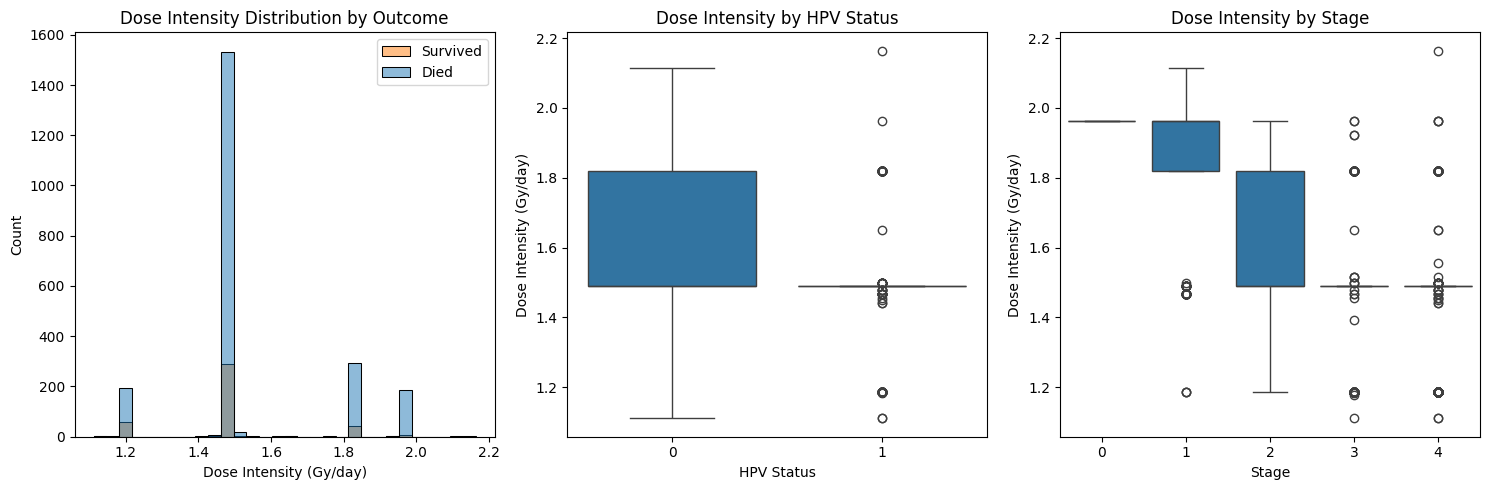

In [5]:
plt.figure(figsize=(15, 5))

# Plot 1: Dose intensity distribution
plt.subplot(1, 3, 1)
sns.histplot(data=df, x='dose_intensity', hue='Y', bins=30)
plt.title('Dose Intensity Distribution by Outcome')
plt.xlabel('Dose Intensity (Gy/day)')
plt.legend(['Survived', 'Died'])

# Plot 2: Dose by HPV status
plt.subplot(1, 3, 2)
sns.boxplot(data=df, x='HPV_Positive', y='dose_intensity')
plt.title('Dose Intensity by HPV Status')
plt.ylabel('Dose Intensity (Gy/day)')
plt.xlabel('HPV Status')

# Plot 3: Dose by Stage
plt.subplot(1, 3, 3)
sns.boxplot(data=df, x='Stage_numeric', y='dose_intensity')
plt.title('Dose Intensity by Stage')
plt.ylabel('Dose Intensity (Gy/day)')
plt.xlabel('Stage')

plt.tight_layout()
plt.show()

In [6]:
# more baseline characteristics
baseline_stats = pd.DataFrame({
    'Mean': df[['Age', 'Smoking_PY', 'dose_intensity']].mean(),
    'SD': df[['Age', 'Smoking_PY', 'dose_intensity']].std(),
    'Min': df[['Age', 'Smoking_PY', 'dose_intensity']].min(),
    'Max': df[['Age', 'Smoking_PY', 'dose_intensity']].max()
})

categorical_stats = pd.DataFrame({
    'Count': [
        df['Sex'].value_counts(),
        df['HPV_Positive'].value_counts(),
        df['Chemo'].value_counts(),
        df['Stage_numeric'].value_counts()
    ]
}).T

print("Continuous Variables Summary:")
display(baseline_stats)
print("\nCategorical Variables Summary:")
display(categorical_stats)


Continuous Variables Summary:


,Mean,SD,Min,Max
Age,63.493889,10.697731,22.300000,90.000000
Smoking_PY,27.615429,24.678065,0.000000,240.000000
dose_intensity,1.536632,0.193507,1.111111,2.163934



Categorical Variables Summary:


,0,1,2,3
Count,"Sex 1 2158 0 493 Name: count, dtype: int64","HPV_Positive 0 1599 1 1052 Name: count, ...","Chemo 0 1663 1 988 Name: count, dtype: ...",Stage_numeric 4 1561 3 417 2 343 1 ...


In [9]:
cf = CausalForestDML(
    model_y=RandomForestRegressor(n_estimators=100),
    model_t=RandomForestRegressor(n_estimators=100),
    n_estimators=1000, #can change this from 1000 to 2000
    random_state=42
)
cf.fit(Y=df['Y'], T=T_scaled.ravel(), X=X)

In [ ]:
# individual treatment effects and ATE
te_pred = cf.effect(X)
ate = np.mean(te_pred)

# Bootstrap inference for overall ATE
inference = BootstrapInference(n_bootstrap_samples=100) # change 100 to higher num like 2000
inference.fit(cf, Y=df['Y'], T=T_scaled.ravel(), X=X)
ate_interval = inference.confidence_intervals(alpha=0.05)

print(f"Overall Average Treatment Effect (per SD increase in dose intensity): {ate:.3f}")
print(f"95% CI: ({ate_interval[0][0]:.3f}, {ate_interval[0][1]:.3f})")

# i created bins for numerical variables
subgroup_results = {}
num_bins = 3

# HPV analysis
for hpv in [0, 1]:
    mask = df['HPV_Positive'] == hpv
    subgroup_results[f'HPV_{hpv}_ate'] = np.mean(te_pred[mask])
    
    # Fit inference on subgroup
    inference.fit(cf, Y=df['Y'][mask], T=T_scaled.ravel()[mask], X=X.loc[mask])
    ci = inference.confidence_intervals(alpha=0.05)
    subgroup_results[f'HPV_{hpv}_ci'] = (ci[0][0], ci[0][1])

# Stage analysis
stage_bins = pd.qcut(df['Stage_numeric'], num_bins, labels=['Low', 'Medium', 'High'])
for stage in stage_bins.unique():
    mask = stage_bins == stage
    subgroup_results[f'Stage_{stage}_ate'] = np.mean(te_pred[mask])
    
    inference.fit(cf, Y=df['Y'][mask], T=T_scaled.ravel()[mask], X=X.loc[mask])
    ci = inference.confidence_intervals(alpha=0.05)
    subgroup_results[f'Stage_{stage}_ci'] = (ci[0][0], ci[0][1])

# Age analysis
age_bins = pd.qcut(df['Age'], num_bins, labels=['Young', 'Middle', 'Older'])
for age in age_bins.unique():
    mask = age_bins == age
    subgroup_results[f'Age_{age}_ate'] = np.mean(te_pred[mask])
    
    inference.fit(cf, Y=df['Y'][mask], T=T_scaled.ravel()[mask], X=X.loc[mask])
    ci = inference.confidence_intervals(alpha=0.05)
    subgroup_results[f'Age_{age}_ci'] = (ci[0][0], ci[0][1])


# results
print("\nSubgroup Analysis Results:")
for key in sorted(subgroup_results.keys()):
    if '_ci' not in key:
        effect = subgroup_results[key]
        ci = subgroup_results[f'{key}_ci']
        print(f"{key}: {effect:.3f} (95% CI: {ci[0]:.3f}, {ci[1]:.3f})")

plt.figure(figsize=(12, 6))
effects = []
cis = []
labels = []

for key in sorted(subgroup_results.keys()):
    if '_ci' not in key:
        effects.append(subgroup_results[key])
        cis.append(subgroup_results[f'{key}_ci'])
        labels.append(key)

effects = np.array(effects)
cis = np.array(cis)

x_pos = np.arange(len(effects))
plt.errorbar(x_pos, effects, 
             yerr=[effects - cis[:, 0], cis[:, 1] - effects],
             fmt='o', capsize=5, capthick=2)

plt.xticks(x_pos, labels, rotation=45, ha='right')
plt.ylabel('Treatment Effect')
plt.title('Treatment Effects by Subgroup with 95% CI')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [22]:
subgroup_results = {}

# Initialize bootstrap inference
inference = BootstrapInference(n_bootstrap_samples=100)

# HPV Status Analysis
for hpv in [0, 1]:
    mask = df['HPV_Positive'] == hpv
    subgroup_results[f'HPV_{hpv}_ate'] = np.mean(te_pred[mask])
    
    # Fit inference on subgroup
    inference.fit(cf, Y=df['Y'][mask], T=T_scaled.ravel()[mask], X=X.loc[mask])
    subgroup_ci = inference.confidence_intervals(alpha=0.05)
    subgroup_results[f'HPV_{hpv}_ci_lower'] = subgroup_ci[0][0]
    subgroup_results[f'HPV_{hpv}_ci_upper'] = subgroup_ci[0][1]

# Stage Analysis
for stage in sorted(df['Stage_numeric'].unique()):
    mask = df['Stage_numeric'] == stage
    subgroup_results[f'Stage_{stage}_ate'] = np.mean(te_pred[mask])
    
    # Fit inference on subgroup
    inference.fit(cf, Y=df['Y'][mask], T=T_scaled.ravel()[mask], X=X.loc[mask])
    subgroup_ci = inference.confidence_intervals(alpha=0.05)
    subgroup_results[f'Stage_{stage}_ci_lower'] = subgroup_ci[0][0]
    subgroup_results[f'Stage_{stage}_ci_upper'] = subgroup_ci[0][1]

# Chemo Analysis
for chemo in [0, 1]:
    mask = df['Chemo'] == chemo
    subgroup_results[f'Chemo_{chemo}_ate'] = np.mean(te_pred[mask])
    
    # Fit inference on subgroup
    inference.fit(cf, Y=df['Y'][mask], T=T_scaled.ravel()[mask], X=X.loc[mask])
    subgroup_ci = inference.confidence_intervals(alpha=0.05)
    subgroup_results[f'Chemo_{chemo}_ci_lower'] = subgroup_ci[0][0]
    subgroup_results[f'Chemo_{chemo}_ci_upper'] = subgroup_ci[0][1]

# Print results with confidence intervals
print("\nSubgroup Analysis (effects per SD increase in dose intensity):")
for group in ['HPV', 'Stage', 'Chemo']:
    print(f"\n{group} Status Analysis:")
    for key in sorted([k for k in subgroup_results.keys() if k.startswith(group) and 'ci' not in k]):
        effect = subgroup_results[key]
        ci_lower = subgroup_results[f'{key}_ci_lower']
        ci_upper = subgroup_results[f'{key}_ci_upper']
        print(f"{key}: {effect:.3f} (95% CI: {ci_lower:.3f}, {ci_upper:.3f})")

# Visualize subgroup effects
plt.figure(figsize=(12, 6))
x_pos = np.arange(len([k for k in subgroup_results.keys() if 'ci' not in k]))
effects = [v for k, v in subgroup_results.items() if 'ci' not in k]
ci_lower = [subgroup_results[f'{k}_ci_lower'] for k in subgroup_results.keys() if 'ci' not in k]
ci_upper = [subgroup_results[f'{k}_ci_upper'] for k in subgroup_results.keys() if 'ci' not in k]

plt.errorbar(x_pos, effects, yerr=[np.array(effects) - np.array(ci_lower), 
                                  np.array(ci_upper) - np.array(effects)],
             fmt='o', capsize=5, capthick=2)

plt.xticks(x_pos, [k for k in subgroup_results.keys() if 'ci' not in k], rotation=45)
plt.ylabel('Treatment Effect')
plt.title('Treatment Effects by Subgroup with 95% CI')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

KeyboardInterrupt: 

In [ ]:
plt.figure(figsize=(15, 12))

# Plot 1: Distribution of treatment effects
plt.subplot(2, 2, 1)
sns.histplot(te_pred, kde=True, bins=30)
plt.axvline(ate, color='red', linestyle='--', label=f'ATE: {ate:.3f}')
plt.title('Distribution of Individual Treatment Effects')
plt.xlabel('Effect on Mortality Risk')
plt.ylabel('Count')
plt.legend()

# Plot 2: Effects by stage with confidence intervals
plt.subplot(2, 2, 2)
stage_data = []
stages = sorted(df['Stage_numeric'].unique())
for stage in stages:
    mask = df['Stage_numeric'] == stage
    stage_data.append({
        'Stage': stage,
        'Effect': np.mean(te_pred[mask]),
        'CI_lower': subgroup_results[f'Stage_{stage}_ci_lower'],
        'CI_upper': subgroup_results[f'Stage_{stage}_ci_upper']
    })
stage_df = pd.DataFrame(stage_data)
    
plt.errorbar(stage_df['Stage'], stage_df['Effect'], 
             yerr=[stage_df['Effect'] - stage_df['CI_lower'], 
                   stage_df['CI_upper'] - stage_df['Effect']],
             fmt='o', capsize=5)
plt.title('Treatment Effects by Stage')
plt.xlabel('Stage')
plt.ylabel('Effect on Mortality Risk')

# Plot 3: Effects by HPV status with confidence intervals
plt.subplot(2, 2, 3)
hpv_effects = pd.DataFrame({
    'HPV Status': ['Negative', 'Positive'],
    'Effect': [subgroup_results['HPV_0_ate'], subgroup_results['HPV_1_ate']],
    'CI_lower': [subgroup_results['HPV_0_ci_lower'], subgroup_results['HPV_1_ci_lower']],
    'CI_upper': [subgroup_results['HPV_0_ci_upper'], subgroup_results['HPV_1_ci_upper']]
})
plt.errorbar(range(2), hpv_effects['Effect'],
             yerr=[hpv_effects['Effect'] - hpv_effects['CI_lower'],
                   hpv_effects['CI_upper'] - hpv_effects['Effect']],
             fmt='o', capsize=5)
plt.xticks(range(2), ['HPV-', 'HPV+'])
plt.title('Treatment Effects by HPV Status')
plt.ylabel('Effect on Mortality Risk')

# Plot 4: Effects by Chemo status with confidence intervals
plt.subplot(2, 2, 4)
chemo_effects = pd.DataFrame({
    'Chemo': ['No', 'Yes'],
    'Effect': [subgroup_results['Chemo_0_ate'], subgroup_results['Chemo_1_ate']],
    'CI_lower': [subgroup_results['Chemo_0_ci_lower'], subgroup_results['Chemo_1_ci_lower']],
    'CI_upper': [subgroup_results['Chemo_0_ci_upper'], subgroup_results['Chemo_1_ci_upper']]
})
plt.errorbar(range(2), chemo_effects['Effect'],
             yerr=[chemo_effects['Effect'] - chemo_effects['CI_lower'],
                   chemo_effects['CI_upper'] - chemo_effects['Effect']],
             fmt='o', capsize=5)
plt.xticks(range(2), ['No Chemo', 'Chemo'])
plt.title('Treatment Effects by Chemotherapy Status')
plt.ylabel('Effect on Mortality Risk')

plt.tight_layout()
plt.show()


In [ ]:
feature_importance = pd.DataFrame({
    'Feature': feature_cols,
    'Importance': np.mean(np.abs(cf.feature_importances_), axis=0)
})
feature_importance = feature_importance.sort_values('Importance', ascending=True)

plt.figure(figsize=(10, 6))
feature_importance.plot(kind='barh', x='Feature', y='Importance')
plt.title('Feature Importance in Treatment Effect Heterogeneity')
plt.xlabel('Mean Absolute CATE Difference')
plt.tight_layout()
plt.show()

In [ ]:
# results = {
#     'ATE': ate,
#     'CI_lower': ate_interval[0],
#     'CI_upper': ate_interval[1],
#     **subgroup_results
# }

# pd.DataFrame([results]).to_csv('causal_analysis_results.csv', index=False)

# feature_importance.to_csv('feature_importance.csv', index=False)

# individual_effects = pd.DataFrame({
#     'patient_id': df.index,
#     'treatment_effect': te_pred,
#     'dose_intensity': df['dose_intensity'],
#     'HPV_status': df['HPV_Positive'],
#     'Stage': df['Stage_numeric'],
#     'Chemo': df['Chemo']
# })
# individual_effects.to_csv('individual_treatment_effects.csv', index=False)

# print("\nAnalysis complete. Results saved to:")
# print("1. 'causal_analysis_results.csv' - Main results with ATE and subgroup effects")
# print("2. 'feature_importance.csv' - Feature importance analysis")
# print("3. 'individual_treatment_effects.csv' - Patient-level treatment effects")